## This notebook can be used to save the dense representation of a DeepSVG model to a pkl file

It should be run using the environment created from the requirements.txt file in the SVGRepresentation folder.

The following code expects the folder 'SVG_Data' to be in the same directory as the cloned project repository.
```
parent/
    ├── SVG_Data
    └── SVG_LogoGenerator
```
If this is not the case on your machine make sure to
* set the correct path to the SVG_Data folder here:


In [1]:
datafolder = "../../../SVG_Data/"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir("../deepsvg")

In [4]:
from deepsvg.svglib.svg import SVG
from deepsvg import utils
from deepsvg.difflib.tensor import SVGTensor
from deepsvg.svglib.geom import Bbox
from deepsvg.svgtensor_dataset import load_dataset
from deepsvg.utils.utils import batchify
import torch
import pandas as pd

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

 ### Helper functions:


In [6]:
def load_svg(filename):
    svg = SVG.load_svg(filename)
    svg = dataset.simplify(svg)
    svg = dataset.preprocess(svg)
    return svg

In [7]:
def encode(data):
    model_args = batchify((data[key] for key in cfg.model_args), device)
    with torch.no_grad():
        z = model(*model_args, encode_mode=True)
        return z

def encode_icon(idx):
    data = dataset.get(id=idx, random_aug=False)
    return encode(data)
    
def encode_svg(svg):
    data = dataset.get(svg=svg)
    return encode(data)

def decode(z, do_display=True, return_svg=False, return_png=False):
    commands_y, args_y = model.greedy_sample(z=z)
    tensor_pred = SVGTensor.from_cmd_args(commands_y[0].cpu(), args_y[0].cpu())
    svg_path_sample = SVG.from_tensor(tensor_pred.data, viewbox=Bbox(256), allow_empty=True).normalize().split_paths().set_color("random")
    
    if return_svg:
        return svg_path_sample
    
    return svg_path_sample.draw(do_display=do_display, return_png=return_png)

 ### Load the trained model and dataset

In [8]:
pretrained_path = os.path.join(datafolder, "deepsvg_training_logs/16g-62seq-128c-256z-deepsvg-icons/models/deepsvg/hierarchical_ordered_new_data/best.pth.tar")
from configs.deepsvg.hierarchical_ordered_new_data import Config

cfg = Config()
model = cfg.make_model().to(device)
utils.load_model(pretrained_path, model)
model.eval();

In [9]:
dataset = load_dataset(cfg)
meta_file = pd.read_csv(os.path.join(datafolder, "data_for_training_deepsvg_model/icons_meta.csv"))

 ### Inspect an encoding


In [10]:
svg1_latent_rep = encode_icon(1)

In [11]:
svg1_latent_rep.shape

torch.Size([1, 1, 1, 256])

In [12]:
svg1_latent_rep

tensor([[[[ 0.0787,  0.1094,  0.1121, -0.1543,  0.0174,  0.0748,  0.0833,
            0.0980,  0.0094, -0.2035,  0.0509,  0.0371,  0.1414,  0.0367,
           -0.1606, -0.1004, -0.1370, -0.2025,  0.0081, -0.1318,  0.0534,
            0.0733,  0.2417,  0.0075,  0.1242, -0.0746,  0.0848, -0.1136,
            0.0408, -0.0566, -0.0141,  0.0060,  0.0247, -0.0285,  0.0709,
            0.0654,  0.0382, -0.1433,  0.1311,  0.0380, -0.1332,  0.1894,
           -0.2546, -0.2028, -0.0363,  0.0416,  0.3167, -0.2446, -0.1335,
            0.0606,  0.1560,  0.0377, -0.2322,  0.0583,  0.0247, -0.0560,
           -0.0761, -0.0184, -0.0685,  0.1575,  0.1370, -0.2069,  0.4353,
            0.0899, -0.0268, -0.1928,  0.1368, -0.1049,  0.1024, -0.1501,
            0.0724, -0.1745,  0.0493,  0.0780, -0.0518,  0.2505,  0.1303,
            0.0711,  0.0944,  0.0413,  0.0097,  0.1422, -0.0526, -0.0419,
           -0.3117,  0.0707, -0.1062,  0.0531,  0.1219, -0.0082, -0.1881,
            0.1019, -0.1973, -0.1224, 

### Decode

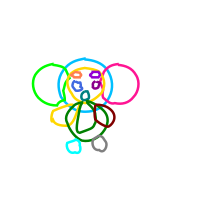

In [13]:
decode(svg1_latent_rep)

 ### Create pkl of list of all encodings for the dataset

In [ ]:
relevant_samples = meta_file[(meta_file.total_len <= 128) & (meta_file.nb_groups <= 16) & (meta_file.max_len_group <= 62)]
print(len(relevant_samples), "relevant samples")
relevant_indices = pd.to_numeric(relevant_samples.id).tolist()
relevant_indices
encodings = []

for i in relevant_indices:
    try:
        encoding = encode_icon(i)
        encodings.append(encoding)
    except: 
        print("encoding failed for sample with id=",i)
   

58669 relevant samples


In [74]:
len(encodings) # all samples succesfully encoded!

58669

### Save the pkl file

In [75]:
import pickle
with open(os.path.join(datafolder, "deepsvg_dense_representations/16g-62seq-128c-256z-encodings.pkl"), "wb") as f:
    pickle.dump(encodings, f, pickle.HIGHEST_PROTOCOL)